In [100]:
import altair as alt
import pandas as pd
import pymc3
alt.renderers.enable('svg')
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
df = pd.DataFrame({
    'crashes': [10, 10, 15, 10, 13, 15, 11, 13, 11, 14, 7, 12, 7, 8, 5],
    'year': list(range(2003, 2018))
})

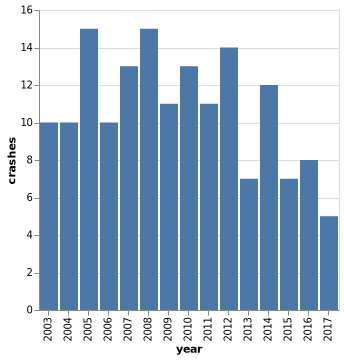

In [3]:
alt.Chart(df).mark_bar().encode(x='year:O', y='crashes')

In [41]:
with pymc3.Model() as road_diet_model:
    
    switchpoint = pymc3.DiscreteUniform(
        'switchpoint',
        lower=df.year.min(),
        upper=df.year.max()
    )
    
    early_rate = pymc3.Exponential('early_rate', 1./df.crashes.mean())
    late_rate = pymc3.Exponential('late_rate', 1./df.crashes.mean())
    rate = pymc3.math.switch(switchpoint >= df.year, early_rate, late_rate)
    crashes = pymc3.Poisson('crashes', rate, observed=df.crashes)
    trace = pymc3.sample(10000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [switchpoint]
>NUTS: [late_rate, early_rate]
Sampling 4 chains: 100%|██████████| 42000/42000 [00:10<00:00, 3893.28draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8871129235001857, but should be close to 0.8. Try to increase the number of tuning steps.
There were 151 divergences after tuning. Increase `target_accept` or reparameterize.
There were 113 divergences after tuning. Increase `target_accept` or reparameterize.
There were 550 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6252090620175822, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [42]:
trace_df = pd.DataFrame({
    'switchpoint': trace['switchpoint'],
    'early_rate': trace['early_rate'],
    'late_rate': trace['late_rate']
})

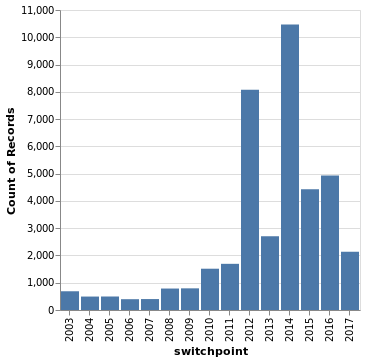

In [43]:
alt.Chart(trace_df).mark_bar().encode(alt.X('switchpoint:O'), y='count()')

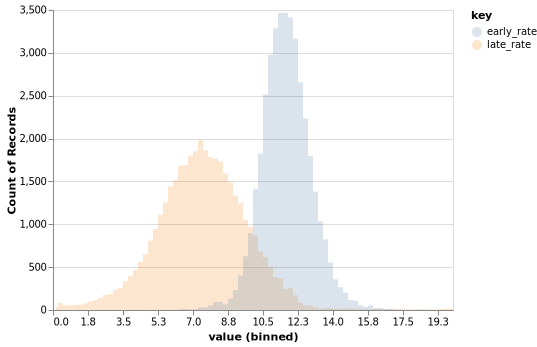

In [126]:
alt.Chart(trace_df).transform_fold(
    ['late_rate', 'early_rate']
).mark_area(
    opacity=0.2, interpolate='step', clip=True
).encode(
    alt.X('value:Q', bin=alt.Bin(step=0.25), scale=alt.Scale(domain=(0, 20))),
    alt.Y('count()', stack=None),
    color='key:N'
)

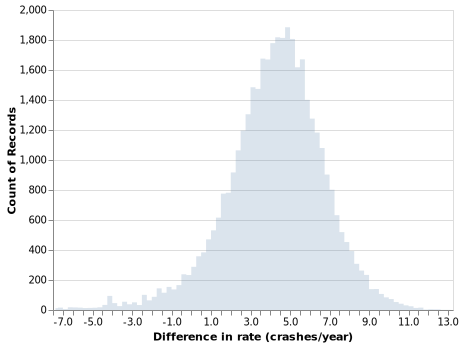

In [119]:
trace_df['rate_diff'] = trace_df.early_rate-trace_df.late_rate
alt.Chart(trace_df[trace_df.rate_diff > -7]).mark_area(
    opacity=0.2, interpolate='step', clip=True
).encode(
    alt.X('rate_diff:Q', title="Difference in rate (crashes/year)", bin=alt.Bin(step=0.25)),
    alt.Y('count()'),
)

In [105]:
trace_df['change'] = (-trace_df.rate_diff/trace_df.early_rate)*100

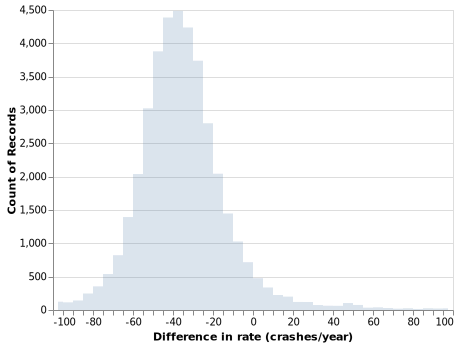

In [110]:
alt.Chart(trace_df[trace_df.change < 100]).mark_area(
    opacity=0.2, interpolate='step', clip=True
).encode(
    alt.X('change:Q', title="Difference in rate (crashes/year)", bin=alt.Bin(step=5)),
    alt.Y('count()'),
)

In [111]:
pymc3.stats.hpd(trace_df.change)

array([-81.69883905,  12.34543327])

In [114]:
trace_df.change.mean()

-33.3154123560549

In [124]:
sum(trace_df.rate_diff > 0)/len(trace_df)

0.93925